In [19]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('merged_data.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.head()

,Game_date,Games_played_to_date,BA,PA,Name,ISO,SLG,BABIP,BIP,OBP,...,strike_percentage,pitches_per_appearance_avg,ground_ball_percentage,fly_ball_percentage,strikeout_percentage,next_game_team1,next_game_team2,hitter_R%,hitter_L%,next_game_hit_vs_fp
0,2014-03-31,1,0.00000,4,Travis d'Arnaud,0.0,0.00000,0.00000,0.33333,0.25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0
1,2014-03-31,1,0.20000,5,Jayson Werth,0.0,0.20000,0.33333,0.60000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
2,2014-03-31,1,0.25000,5,Ian Desmond,0.0,0.25000,0.25000,1.00000,0.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1
3,2014-03-31,1,0.25000,5,Bryce Harper,0.0,0.25000,0.50000,0.50000,0.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0
4,2014-03-31,1,0.33333,5,Adam LaRoche,1.0,1.33333,0.00000,1.00000,0.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1


In [21]:
train = df[["PA","BA","pHitsByZone3", "hitter_R%", "BIP", "BABIP", "LA_median", "Weather (Degrees)", "Wind (MPH)", "Area_stand", 
            "Altitude", "H", "RUNS", "pitches_per_appearance_avg", "strikeout_percentage", "hip_last_three", 
            "ground_ball_percentage", "Strikes_Swinging"]]
test = df[['next_game_HIT']]

In [22]:
for i in train.columns:    
    if (train.shape[0] - train[i].count()) / train.shape[0] > .3:
        print (i)
        train = train.drop([i], axis = 1)

pHitsByZone3


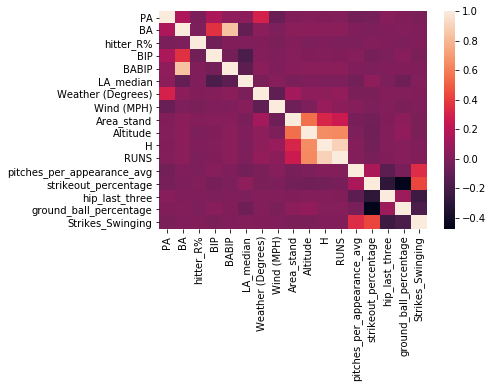

In [23]:
corr = train.corr()
sns.heatmap(corr)

In [24]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]
train = train[selected_columns]

In [25]:
for i in train.columns:
    if len(train[i].unique()) > 2:
        train[i] = train[i].fillna(train[i].median())
    else:
        train[i] = train[i].fillna(train[i].mode()[0])

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.20, shuffle = False)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

clf = LogisticRegression(solver = 'sag', max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print (scores)

0.638722294654498
[0.64857161 0.64747036 0.64805338 0.64805338 0.64809536 0.64796579
 0.6491319  0.64841928 0.64783623 0.64770666]


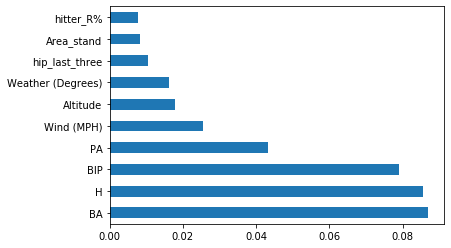

In [28]:
feat_importances = pd.Series(clf.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind = 'barh')

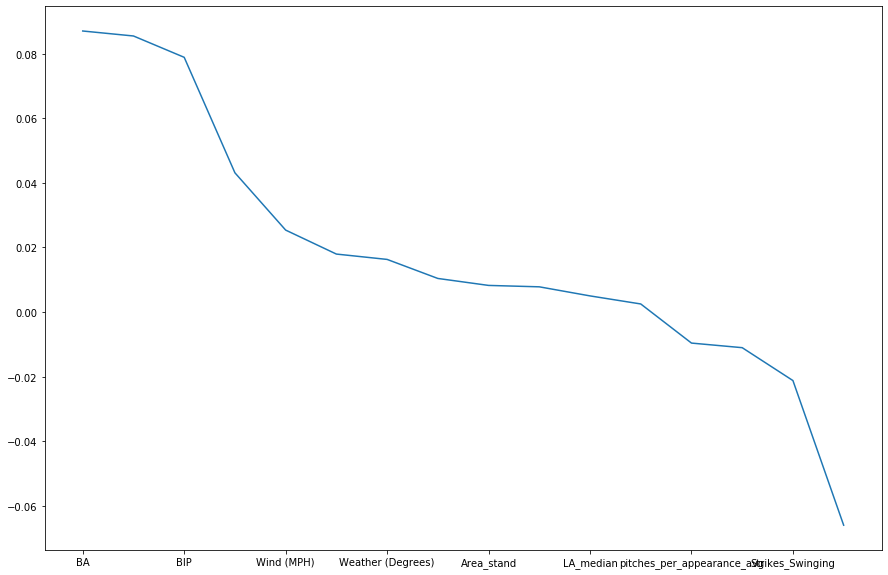

In [29]:
feat_importances.nlargest(len(feat_importances)).plot(kind = 'line', figsize = (15, 10))

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score

clf = SGDClassifier(loss="log", max_iter = 3000)
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))
scores = cross_val_score(clf, X_train, y_train.values.ravel(), cv=10)
print (scores)

0.6400982126356364
[0.64824772 0.64591566 0.64753514 0.64507352 0.64692926 0.64362529
 0.6463462  0.6459575  0.64323659 0.64880798]


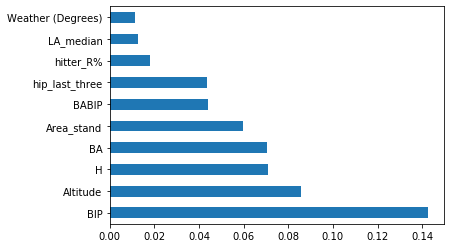

In [31]:
feat_importances = pd.Series(clf.coef_[0], index=train.columns)
feat_importances.nlargest(10).plot(kind = 'barh')

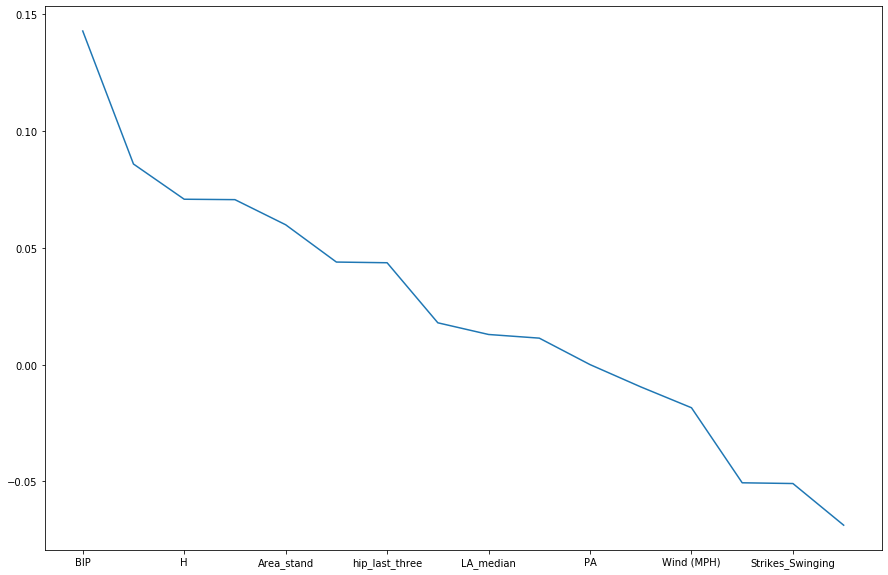

In [32]:
feat_importances.nlargest(len(feat_importances)).plot(kind = 'line', figsize = (15, 10))

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train.values.ravel())
predictions = clf.predict(X_test)
print (precision_score(y_test, predictions))

0.6450536617916921


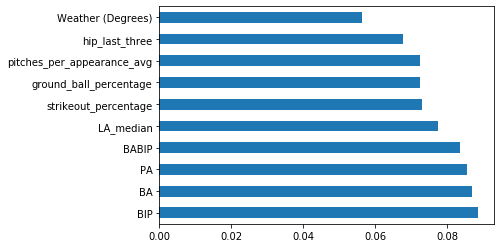

In [34]:
feat_importances = pd.Series(clf.feature_importances_, index=train.columns)
feat_importances.nlargest(10).plot(kind='barh')

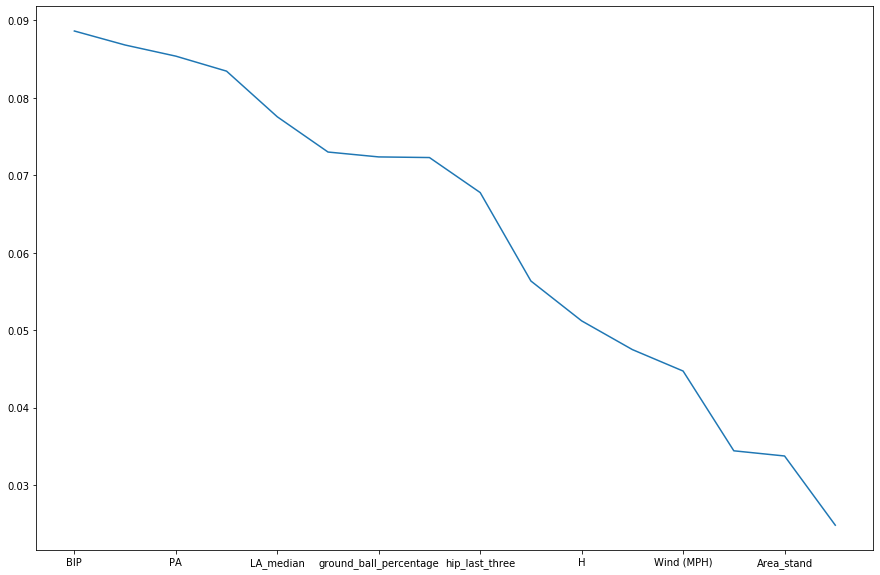

In [35]:
feat_importances.nlargest(len(feat_importances)).plot(kind='line', figsize = (15, 10))

In [36]:
train = train.join(df['Name'])
train = train.join(df['next_game_HIT'])
names = train['Name'].unique().tolist()
temp = train['Name'].value_counts().to_frame()
temp = temp.reset_index()
temp.columns = ['Name', 'Count']
for i in range(len(temp)):
    if temp.at[i, 'Count'] < 200:
        names.remove(temp.at[i, 'Name'])

In [37]:
train

,PA,BA,hitter_R%,BIP,BABIP,LA_median,Weather (Degrees),Wind (MPH),Area_stand,Altitude,H,pitches_per_appearance_avg,strikeout_percentage,hip_last_three,ground_ball_percentage,Strikes_Swinging,Name,next_game_HIT
0,4,0.00000,1.000000,0.33333,0.00000,16.60,51,4,0.219493,13.0,0.918,92.500000,0.223152,0.989011,0.350993,9.0,Travis d'Arnaud,0.0
1,5,0.20000,1.000000,0.60000,0.33333,16.60,51,4,0.219493,13.0,0.918,92.500000,0.223152,0.989011,0.350993,9.0,Jayson Werth,1.0
2,5,0.25000,1.000000,1.00000,0.25000,16.60,51,4,0.219493,13.0,0.918,92.500000,0.223152,0.989011,0.350993,9.0,Ian Desmond,1.0
3,5,0.25000,0.000000,0.50000,0.50000,16.60,51,4,0.219493,13.0,0.918,92.500000,0.223152,0.989011,0.350993,9.0,Bryce Harper,0.0
4,5,0.33333,0.000000,1.00000,0.00000,16.60,51,4,0.219493,13.0,0.918,92.500000,0.223152,0.989011,0.350993,9.0,Adam LaRoche,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192951,70,0.24590,1.000000,0.54098,0.40000,18.80,72,0,0.136598,41.0,0.901,96.923077,0.253311,0.872093,0.238411,7.0,Drew Stubbs,1.0
192952,143,0.28346,0.201728,0.73846,0.34066,24.55,72,0,0.136598,41.0,0.901,49.187500,0.244957,0.789474,0.285303,9.0,Nick Franklin,1.0
192953,349,0.26250,1.000000,0.85231,0.28253,16.30,72,0,0.136598,41.0,0.901,96.923077,0.253311,0.872093,0.238411,7.0,J. J. Hardy,1.0
192954,125,0.19298,1.000000,0.77966,0.23913,18.90,72,0,0.136598,41.0,0.901,96.923077,0.253311,0.872093,0.238411,7.0,Caleb Joseph,0.0


In [38]:
len(df['Name'].unique()) - len(names)

717

In [39]:
len(names) / len(df['Name'].unique()) 

0.32358490566037734

In [40]:
players = pd.DataFrame()

count = 0

for name in names:
    
    players.at[count, 'Name'] = name
    
    train2 = train[train['Name'] == name]
    train2 = train2.drop(['Name'], axis = 1)
    test2 = train2['next_game_HIT']
    train2 = train2.drop(['next_game_HIT'], axis = 1)
    
    players.at[count, 'Samples'] = train2.shape[0]
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    X_train, X_test, y_train, y_test = train_test_split(train2, test2, test_size = 0.20, shuffle = False)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import precision_score
    
    clf = LogisticRegression(solver = 'sag', max_iter = 3000)
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'LR'] = precision_score(y_test, predictions)
    
    from sklearn.linear_model import SGDClassifier
    from sklearn.metrics import precision_score
    
    clf = SGDClassifier(loss = 'log', max_iter = 3000)
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'SGD'] = precision_score(y_test, predictions)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import precision_score
    
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train.values.ravel())
    predictions = clf.predict(X_test)
    players.at[count, 'RF'] = precision_score(y_test, predictions) 
    
    count += 1
               
players.head()

,Name,Samples,LR,SGD,RF
0,Travis d'Arnaud,365.0,0.703704,0.774194,0.719298
1,Jayson Werth,376.0,0.611111,0.620690,0.608696
2,Ian Desmond,649.0,0.658730,0.585714,0.707071
3,Bryce Harper,728.0,0.623288,0.604167,0.646154
4,Juan Lagares,335.0,0.519231,0.459016,0.513514


In [41]:
print ('LR: ' + str(players['LR'].mean()))
print ('SGD: ' + str(players['SGD'].mean()))
print ('RF: ' + str(players['RF'].mean()))

LR: 0.6417963333415205
SGD: 0.6341333298839437
RF: 0.6444266442273259


In [42]:
print ('LR Top 100: ' + str(players.sort_values(by = 'LR', ascending = False).head(100)['LR'].mean()))
print ('SGD Top 100: ' + str(players.sort_values(by = 'SGD', ascending = False).head(100)['SGD'].mean()))
print ('RF Top 100: ' + str(players.sort_values(by = 'RF', ascending = False).head(100)['RF'].mean()))

LR Top 100: 0.7312392651822698
SGD Top 100: 0.7306917335578546
RF Top 100: 0.7312046922918374


In [43]:
players.sort_values(by = 'LR', ascending = False).head()

,Name,Samples,LR,SGD,RF
295,Whit Merrifield,502.0,0.811881,0.782609,0.808081
18,Paul Goldschmidt,807.0,0.791139,0.789474,0.776978
101,Dee Gordon,649.0,0.789062,0.720588,0.801653
99,Nick Markakis,678.0,0.779412,0.803922,0.761905
285,Jose Altuve,717.0,0.777778,0.761062,0.772059


In [44]:
players.sort_values(by = 'SGD', ascending = False).head()

,Name,Samples,LR,SGD,RF
99,Nick Markakis,678.0,0.779412,0.803922,0.761905
251,Willy Adames,216.0,0.771429,0.791667,0.648649
18,Paul Goldschmidt,807.0,0.791139,0.789474,0.776978
241,Jorge Polanco,393.0,0.769231,0.784314,0.746479
322,Carlos Correa,437.0,0.746835,0.783784,0.760000


In [45]:
players.sort_values(by = 'RF', ascending = False).head()

,Name,Samples,LR,SGD,RF
295,Whit Merrifield,502.0,0.811881,0.782609,0.808081
101,Dee Gordon,649.0,0.789062,0.720588,0.801653
46,Ben Revere,346.0,0.757143,0.765957,0.796610
121,Nick Hundley,341.0,0.766667,0.771930,0.785714
293,Cheslor Cuthbert,256.0,0.761905,0.763158,0.783784
